### instruction: https://github.com/fedhere/PUI2017_fb55/blob/master/HW9_fb55/geopandas_census_instructions.ipynb

# Written in python 3

## This notebook is designed to pratice with both geopandas and census data. This is a simple spatial exploratory analysis of census data. The goal is to assess wheather the location of the linkNYC access points is optimal to guarantee a more "democratic" access to the internet.

### 1. PUMA : Public Use Microdata Area
- 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas
- 1.2 plot the PUMA NYC regions

### 2. American Fact Finder data on percentage of houses with broadband internet access
- 2.1 Get data with American Fact Finder (AFF) API
- 2.2 generate a feature for the percentage of households with broadband access
- 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website

### 3. Plot a choropleth of NYC broadband access
### 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.
- combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab
- plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals


### 5.  Find the number of linkNYC locations per person by PUMA
- 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF
- 5.2 find the number of station per 100 people per PUMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

import urllib.request
import requests
import json

import os
import io


## 1. PUMA : Public Use Microdata Area

### 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data


download it as a shape file. When you download a shapefile you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. You can do that with the urllib library in python 3 with the function


    urllib.request.urlretrieve(url, "file.gz")
then unpack the data into your PUIdata directory, then read it in with geopandas, reading in the shape file with the function


    geopandas.GeoDataFrame.from_file(filename)

In [2]:
os.getenv('PUIDATA')

'/Users/apple/Desktop/PUI2017/PUIdata'

In [3]:
loc = os.getenv('PUIDATA') + '/geo_export_e87f1961-b812-4309-a8c7-3e314c75eec4.shp'

In [4]:
pumashp = gpd.GeoDataFrame.from_file(loc)

In [5]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [6]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2 plot the PUMA NYC regions

use the geopandas function plot. What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices.

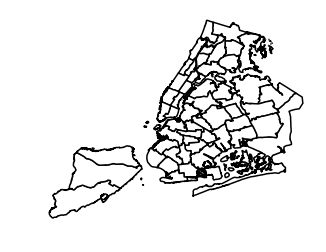

Fig1. the shape of PUMA regions of NYC


In [7]:
ax = plt.figure(figsize = (5,4)).add_subplot(111)
pumashp.plot(ax = ax, column = None, color="white", edgecolor="black", lw=1.5)
plt.axis('off')
plt.show()
print('Fig1. the shape of PUMA regions of NYC')

Prof.: wrote a quick function that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC

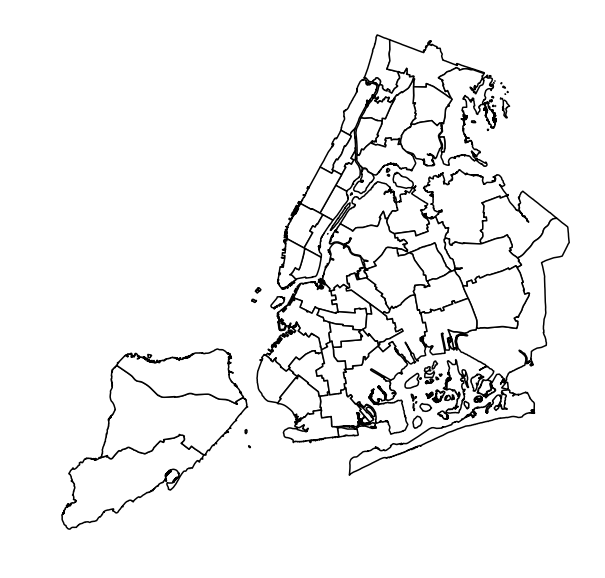

Fig1. the shape of PUMA regions of NYC


In [8]:
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=1.5)
plt.show()
print('Fig1. the shape of PUMA regions of NYC')

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

Get api key from http://api.census.gov/data/key_signup.html

In [9]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI


The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json
read it in as a jason file - you can do it with pandas (but it is slow). You can do it as I do below with the request package

In [10]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [11]:
#aff1y = json.loads(urllib.request.urlopen(url).read())

In [12]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

In [13]:
affkeys

array(['for', 'in', 'B06004HPR_002M', ..., 'B20005I_008MA', 'B12006_025MA',
       'B17020C_011E'], 
      dtype='<U15')

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subs

In [15]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [16]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

## ACS API
The API url is as follows:
root: https://api.census.gov/data/2016/acs/acs1


action: get=[variable Name],NAME


geometry: for=[geometry]:[desired geometry values]in=[larger geometry]:[desired larger geometry values]


API key: key:[api key]


the URL is constructed as **root?action&geometry&key**


Note that it took me a long time to figure out how to request the right geometry: 

in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":*" means all PUMAS
state:36 is New York State

In [17]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content

In [18]:
type(requests.request('GET', url)),type(resp),type(resp.decode('utf-8')),type(io.StringIO(resp.decode('utf-8')))

(requests.models.Response, bytes, str, _io.StringIO)

In [19]:
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [20]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [21]:
pumaBB.shape, pumaPP.shape

((145, 5), (145, 5))

## 2.2 generate a feature for the percentage of households with broadband access

In [22]:
pumaBB = pumaBB.drop(['Unnamed: 4'],axis =1).merge(pumaPP.drop(['Unnamed: 4'],axis =1), 
                                          on = ['NAME','state','public use microdata area'])

In [23]:
pumaBB['pcBB'] = pumaBB.B28002_004E/pumaBB.B28002_001E * 100
pumaBB.rename(columns = {'public use microdata area':'PUMA'},inplace = True)

In [24]:
pumaBB.head()

,B28002_004E,NAME,state,PUMA,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:
    
https://factfinder.census.gov/ -> Advanced Search -> Show me all
- Topics: Product Type -> Geography Comparison Table 
    
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.
Move the file into the PUIdata directory, unzip it and load it with pandas.
Your table shold be labeled as: GCT2801

https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_GCT2801.ST50&prodType=table

In [25]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            skiprows = 1)
bbpc.head()

,Id,Id2,Geography,Target Geo Id,Target Geo Id2,Geographic Area,Geographic Area.1,Percent,Margin of Error
0,0400000US36,36,New York,0400000US36,36,New York,New York,81.7,0.2
1,0400000US36,36,New York,7950000US3600100,3600100,New York - St. Lawrence County PUMA,St. Lawrence County PUMA,80.6,2.6
2,0400000US36,36,New York,7950000US3600200,3600200,"New York - Clinton, Franklin, Essex & Hamilton...","Clinton, Franklin, Essex & Hamilton Counties PUMA",75.7,2.2
3,0400000US36,36,New York,7950000US3600300,3600300,New York - Warren & Washington Counties PUMA,Warren & Washington Counties PUMA,79.8,2.6
4,0400000US36,36,New York,7950000US3600401,3600401,New York - Herkimer (North & Central) & Oneida...,Herkimer (North & Central) & Oneida (Outer) Co...,81.4,2.4


In [26]:
bbpc1 = bbpc.iloc[1:,[3,-2,-1]]
bbpc1.rename(columns = {'Target Geo Id':'GeoId'}, inplace = True)
bbpc1.head() 

,GeoId,Percent,Margin of Error
1,7950000US3600100,80.6,2.6
2,7950000US3600200,75.7,2.2
3,7950000US3600300,79.8,2.6
4,7950000US3600401,81.4,2.4
5,7950000US3600402,78.2,2.3


In [27]:
pumaBB.PUMA

0       100
1       200
2       300
3       401
4       402
5       403
6       500
7       600
8       701
9       702
10      703
11      704
12      800
13      901
14      902
15      903
16      904
17      905
18      906
19     1000
20     1101
21     1102
22     1201
23     1202
24     1203
25     1204
26     1205
27     1206
28     1207
29     1300
       ... 
115    4003
116    4004
117    4005
118    4006
119    4007
120    4008
121    4009
122    4010
123    4011
124    4012
125    4013
126    4014
127    4015
128    4016
129    4017
130    4018
131    4101
132    4102
133    4103
134    4104
135    4105
136    4106
137    4107
138    4108
139    4109
140    4110
141    4111
142    4112
143    4113
144    4114
Name: PUMA, dtype: int64

In [28]:
for i in bbpc1.index:
    if bbpc1.loc[i, 'GeoId'][-4] == '0':
        bbpc1.loc[i, 'PUMA'] = int(bbpc1.loc[i, 'GeoId'][-3:])
    else:
        bbpc1.loc[i, 'PUMA'] = int(bbpc1.loc[i, 'GeoId'][-4:])

In [29]:
bbpc1.drop(['GeoId'], axis = 1,inplace = True)
bbpc1.head()

,Percent,Margin of Error,PUMA
1,80.6,2.6,100.0
2,75.7,2.2,200.0
3,79.8,2.6,300.0
4,81.4,2.4,401.0
5,78.2,2.3,402.0


In [30]:
bbpc1.shape, pumaBB.shape

((145, 3), (145, 6))

In [31]:
pumaBB.head()

,B28002_004E,NAME,state,PUMA,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [32]:
compare = pumaBB.merge(bbpc1, on = 'PUMA')[['PUMA','pcBB','Percent']]
compare.head()

,PUMA,pcBB,Percent
0,100,80.552879,80.6
1,200,75.733321,75.7
2,300,79.842678,79.8
3,401,81.433409,81.4
4,402,78.150656,78.2


In [33]:
compare['diff_'] = np.abs(compare.pcBB - compare.Percent)
compare.diff_.max()

0.049871980407431238

## The max difference is only 0.05%, proving that  the percentage of households with broadband I generated and the one I red in from the table I downloaded manually are the same

# 3. Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [34]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [35]:
pumashp.puma = pumashp.puma.astype('int')
pumashp.rename(columns = {'puma':'PUMA'}, inplace = True)
pumaBBshp = pumashp.merge(pumaBB[['PUMA','pcBB']], on = 'PUMA')
pumaBBshp.head()

,PUMA,shape_leng,shape_area,geometry,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,69.425612


In [36]:
pumaBBshp.shape, bbpc1.shape, pumashp.shape

((55, 5), (145, 3), (55, 4))

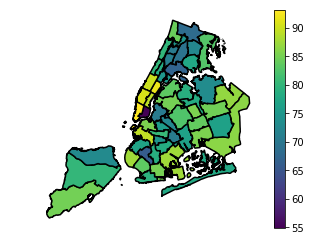

Fig2. percentage of households with broadband access across PUMA of NYC


In [37]:
ax = plt.figure(figsize = (5,4)).add_subplot(111)
pumaBBshp.plot(ax = ax, column = 'pcBB',edgecolor="black",legend=True, lw=1.5)
plt.axis('off')
plt.show()
print('Fig2. percentage of households with broadband access across PUMA of NYC')

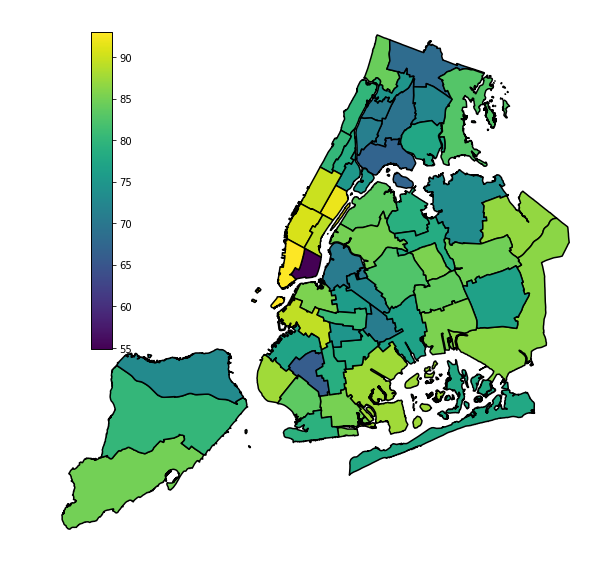

Fig2. percentage of households with broadband access across PUMA of NYC


In [38]:
import choroplethNYC as cp
cp.choroplethNYC(pumaBBshp, column='pcBB', edgecolor="black", lw=1.5)
plt.show()
print('Fig2. percentage of households with broadband access across PUMA of NYC')

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe read it in from the HW9_fb55 folder in : https://github.com/fedhere/PUI2017_fb55
Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [39]:
linknyc = pd.read_csv(os.getenv('PUIDATA') + '/linkNYClocations.csv', index_col = 'Unnamed: 0')

In [40]:
linknyc.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [41]:
linknyc.shape

(1414, 4)

## combine long lat into a column to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon

In [42]:
# combine lat and lon to one column
linknyc['lonlat']=[i for i in zip(linknyc.longitude, linknyc.latitude)]
linknyc.head()

,link_site,longitude,date_link_,latitude,lonlat
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [43]:
import shapely
# Create Point Geometry for based on lonlat column
linknyc['geometry']=linknyc[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linknyc.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


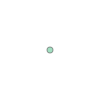

In [44]:
linknyc.iloc[0,5]

In [45]:
type(linknyc.iloc[0,5])

shapely.geometry.point.Point

## plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

color coded the station by how long ago they have been installed, using the date datetime variable

In [46]:
linkNYC = gpd.GeoDataFrame(linknyc, geometry='geometry')

In [47]:
type(linknyc), type(linkNYC)

(pandas.core.frame.DataFrame, geopandas.geodataframe.GeoDataFrame)

In [48]:
import datetime
linkNYC['days'] = (datetime.datetime.now().date()-pd.to_datetime(linkNYC.date_link_)).\
                    apply(lambda x: x.days)
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,days
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753),155
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938),155
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439),155
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042),219
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133),247


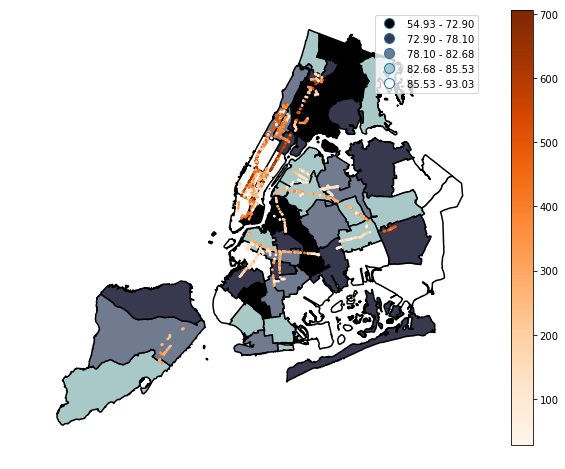

Fig2. Percentage of households with broadband access across PUMA, and linkNYC location, in NYC. The color of map stands for the percentage of broadband access,while the points stand for the linkNYC points with the color meaning the installed days.


In [55]:
# pip install pysal, for scheme
import pysal
ax = plt.figure(figsize = (10,8)).add_subplot(111)
pumaBBshp.plot(ax = ax, column = 'pcBB',edgecolor="black",cmap='bone',
               legend=True, lw=1.5, scheme="quantiles")
linkNYC.plot(ax=ax, column='days',markersize=3,cmap='Oranges',legend=True)

plt.axis('off')
plt.show()
print('Fig2. Percentage of households with broadband access across PUMA, \
and linkNYC location, in NYC. The color of map stands for the percentage of broadband access,\
while the points stand for the linkNYC points with the color meaning the installed days.')

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by variable is B00001_001E, and of course geometry is PUMA, public%20use%20microdata%20area:*, as before

In [61]:
pop = 'B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + pop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPOP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPOP.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [62]:
pumaPOP.rename(columns = {'public use microdata area':'PUMA', 'B00001_001E':'POP'}, inplace = True)
pumaPOP.drop(['Unnamed: 4'], axis = 1, inplace = True)
pumaPOP.PUMA = pumaPOP.PUMA.astype('int')
pumaBB_POP_shp = pumaBBshp.merge(pumaPOP[['PUMA', 'POP']], on = ['PUMA'])
pumaBB_POP_shp.head()

,PUMA,shape_leng,shape_area,geometry,pcBB,POP
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,84.275820,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,68.310015,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,82.826141,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",72.553737,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,69.425612,2011


## 5.2 find the number of station per 100 people per PUMA

Important you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are not "flat coordinates". Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )



(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

In [63]:
from fiona.crs import from_epsg

In [67]:
a = pumaBB_POP_shp.to_crs(epsg = 2263)
linkNYC.crs = from_epsg(4326)
b = linkNYC.to_crs(epsg = 2263)[['link_site', 'geometry','days']]
a.crs, b.crs

({'init': 'epsg:2263', 'no_defs': True},
 {'init': 'epsg:2263', 'no_defs': True})

In [68]:
## install Homebrew: /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
## brew install spatialindex
## pip install rtree
gpd.sjoin(a,b).head()

,PUMA,shape_leng,shape_area,geometry,pcBB,POP,index_right,link_site,days
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",84.275820,1517,1286,bx-08-145850,176
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",69.425612,2011,927,bx-06-118922,44
5,3706,51799.404764,4.388687e+07,"POLYGON ((1008237.008422854 252471.6857909637,...",74.733800,1274,917,bx-05-119659,362
5,3706,51799.404764,4.388687e+07,"POLYGON ((1008237.008422854 252471.6857909637,...",74.733800,1274,25,bx-05-116218,570
5,3706,51799.404764,4.388687e+07,"POLYGON ((1008237.008422854 252471.6857909637,...",74.733800,1274,1283,bx-05-145959,58


In [69]:
a.shape, b.shape, gpd.sjoin(a,b).shape

((55, 6), (1414, 3), (1414, 9))

In [71]:
gpd.sjoin(a,b).groupby('PUMA').count()['link_site'].shape

(37,)

In [72]:
linkpp = gpd.sjoin(a,b).groupby('PUMA').count()[['link_site']].reset_index()
linkpp.head()

,PUMA,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [113]:
linkpp.describe()

,PUMA,link_site
count,37.000000,37.000000
mean,3917.000000,38.216216
std,143.587952,46.499782
min,3701.000000,1.000000
25%,3804.000000,12.000000
50%,4001.000000,25.000000
75%,4011.000000,40.000000
max,4112.000000,230.000000


In [73]:
a.merge(linkpp, how = 'left', on = 'PUMA').shape

(55, 7)

In [111]:
pumashplc = a.merge(linkpp, how = 'left', on = 'PUMA')
pumashplc.link_site.fillna(value = 0, inplace = True)
pumashplc['linkNYCp100p'] = pumashplc.link_site/pumashplc.POP * 100
pumashplc.head()

,PUMA,shape_leng,shape_area,geometry,pcBB,POP,link_site,linkNYCp100p
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",84.275820,1517,1.0,0.065920
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",68.310015,1959,0.0,0.000000
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,82.826141,1305,0.0,0.000000
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",72.553737,1882,0.0,0.000000
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",69.425612,2011,1.0,0.049727


In [112]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

## at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [91]:
pumashplc.crs

{'init': 'epsg:2263', 'no_defs': True}

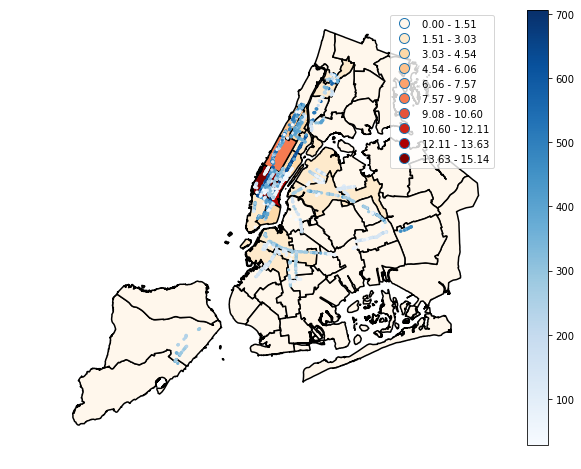

Fig3. Number of linkNYC stations across PUMA and linkNYC location in NYC. The color of map stands for linkNYC stations per 100 people,while the points stand for the linkNYC points with the color meaning the installed days(legend is settled in the right).


In [117]:
ax = plt.figure(figsize = (10,8)).add_subplot(111)
pumashplc.plot(ax = ax, column = 'linkNYCp100p',edgecolor="black",cmap='OrRd',
               lw=1.5, scheme="Equal_interval", legend=True, k=10)
                            

b.plot(ax=ax, column='days', markersize=5,cmap='Blues',legend=True)
plt.axis('off')
plt.show()
print('Fig3. Number of linkNYC stations across PUMA and linkNYC location in NYC. \
The color of map stands for linkNYC stations per 100 people,\
while the points stand for the linkNYC points with the color meaning the installed days\
(legend is settled in the right).')

# Extra credit 1:

How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

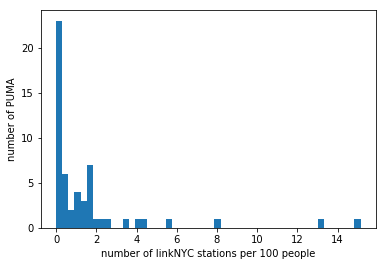

In [123]:
plt.hist(pumashplc.linkNYCp100p, bins = 50)
plt.xlabel('number of linkNYC stations per 100 people')
plt.ylabel('number of PUMA')
plt.show()

# Extra Credit 2:

plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC